<a href="https://colab.research.google.com/github/MohamadYouness/AM_IMAGE_PROCESSING/blob/main/Surface_Inspection_of_Manufactured_Metal_Sheets_AM_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#
# Install required libs
!pip install segmentation-models-pytorch==0.2.0
!pip install albumentations==1.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 22.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12403 sha256=cb582d8c7ee16fa8d2d417d0f990fb6eadc671a21c2a534e94a32fbe927adddc
  Stored in directory: /root/.cache/pip/wheels/61/3a/b0/0b4c443c380bd934701b0a25e4aed76479e4fcaf1a6f955664
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=053443c07d633d68ba649fd24b6d520e6709732c1639cf02636b63a65dc88542
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.5/113.

In [ ]:
# import segmentation_models_pytorch

## Loading data

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks

All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [ ]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch

In [ ]:
torch.cuda.is_available()

True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_DIR = '/content/drive/MyDrive/AM_project'

# load repo with data if it is not exists
# if not os.path.exists(DATA_DIR):
#     print('Loading data...')
#     os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
#     print('Done!')

In [ ]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')



In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [ ]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    CLASSES = ['background','defect']

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # extract certain classes from mask (e.g. cars)
        mask[mask > 0 ] = 1
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)

In [ ]:
# Lets look at data we have
CLASSES = ['defect']
for defect in CLASSES:
    dataset = Dataset(x_train_dir, y_train_dir, classes=[defect])
    for i in range(5):
        image, mask = dataset[i] # get some sample
        # print(mask.shape)
        visualize(
            image=image,
            cars_mask=mask.squeeze(),
        )


### Augmentations

:Data augmentation is a powerful technique to increase the amount of your data

---

and prevent model overfitting.

> Indented block


If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [ ]:
import albumentations as albu

In [ ]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        # albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=256, min_width=512, always_apply=True, border_mode=0),
        albu.RandomCrop(height=256, width=512, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        # albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=0.1),
                albu.RandomBrightness(p=0.1),
                albu.RandomGamma(p=0.1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=0.1),
                albu.Blur(blur_limit=3, p=0.1),
                albu.MotionBlur(blur_limit=3, p=0.1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=0.1),
                albu.HueSaturationValue(p=0.1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(256, 512)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:262: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:232: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1639: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


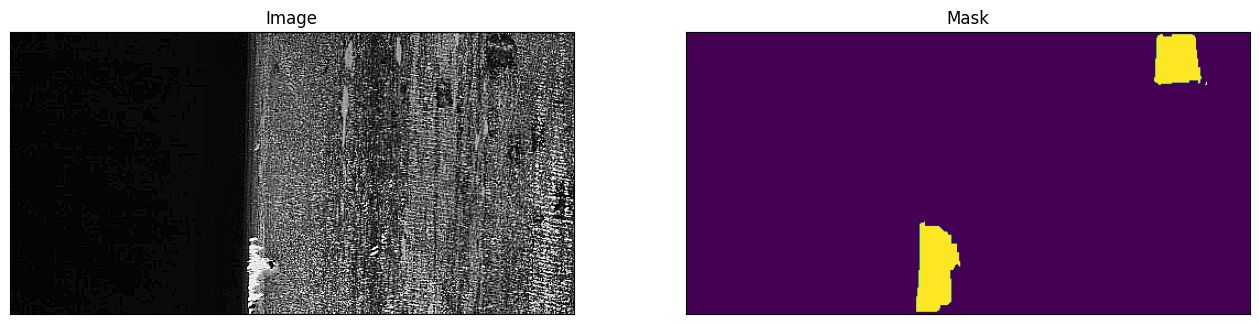

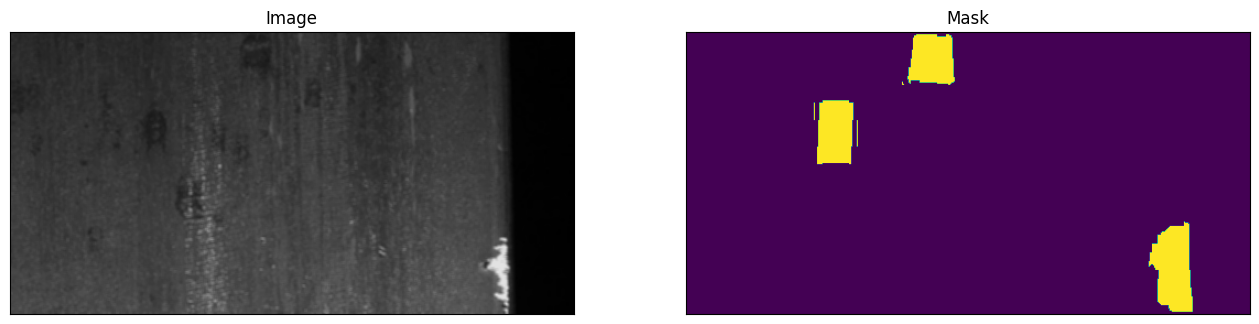

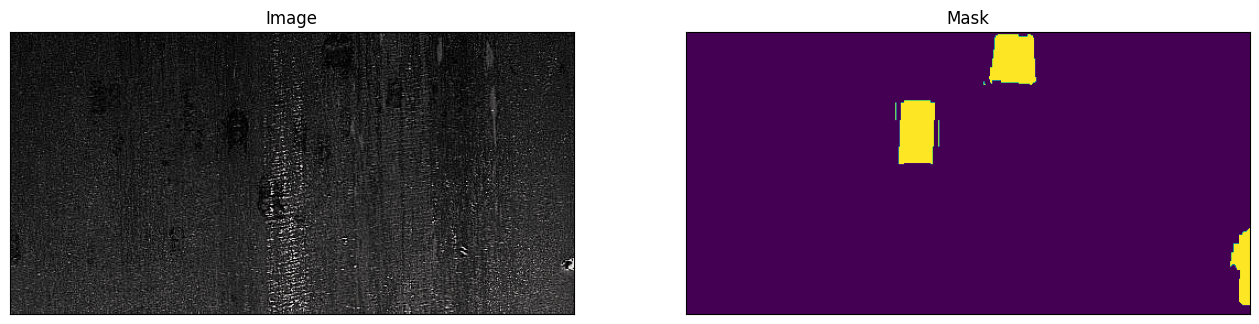

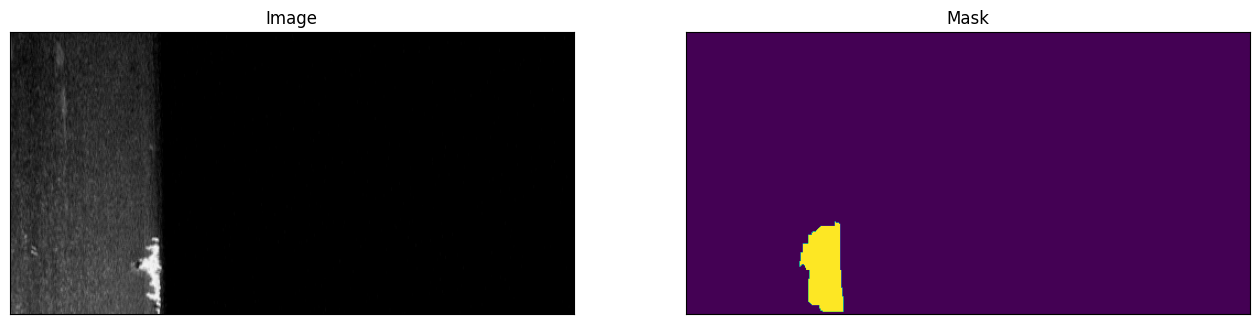

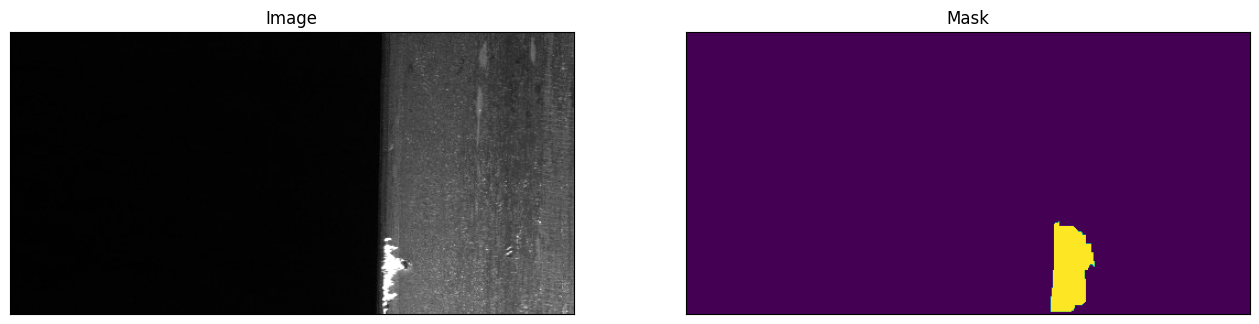

In [ ]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    classes=['defect'],
)

# same image with different random transforms
for i in range(5):

    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze(-1))

In [ ]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [ ]:
ENCODER = 'efficientnet-b4'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['defect']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth
100%|██████████| 74.4M/74.4M [00:00<00:00, 234MB/s]


In [ ]:
train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:262: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:232: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1639: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will cr

In [ ]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
# create epoch runners
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [ ]:
# train model for 40 epochs

max_score = 0

for i in range(0, 40):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, '/content/drive/MyDrive/AM_project/weights/best_model.pth')
        print('Model saved!')

    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 209/209 [01:32<00:00,  2.27it/s, dice_loss - 0.353, iou_score - 0.5308]
Model saved!

Epoch: 1
valid: 100%|██████████| 209/209 [01:31<00:00,  2.27it/s, dice_loss - 0.3106, iou_score - 0.5474]
Model saved!

Epoch: 2
valid: 100%|██████████| 209/209 [01:32<00:00,  2.27it/s, dice_loss - 0.2923, iou_score - 0.5587]
Model saved!

Epoch: 3
valid: 100%|██████████| 209/209 [01:32<00:00,  2.26it/s, dice_loss - 0.2885, iou_score - 0.5634]
Model saved!

Epoch: 4
valid: 100%|██████████| 209/209 [01:31<00:00,  2.28it/s, dice_loss - 0.2989, iou_score - 0.5513]

Epoch: 5
valid: 100%|██████████| 209/209 [01:32<00:00,  2.25it/s, dice_loss - 0.2756, iou_score - 0.5762]
Model saved!

Epoch: 6
valid: 100%|██████████| 209/209 [01:31<00:00,  2.29it/s, dice_loss - 0.2671, iou_score - 0.5858]
Model saved!

Epoch: 7
valid: 100%|██████████| 209/209 [01:32<00:00,  2.26it/s, dice_loss - 0.2697, iou_score - 0.5825]

Epoch: 8
valid: 100%|██████████| 209/209 [01:31<00:00,  2.28it/s, 

KeyboardInterrupt: ignored

## Test best saved model

In [ ]:
# load best saved checkpoint
best_model = torch.load('/content/drive/MyDrive/AM_project/weights/best_model.pth')

In [ ]:
# create test dataset
test_dataset = Dataset(
    '/content/drive/MyDrive/AM_project/CustomImages',
    '/content/drive/MyDrive/AM_project/CustomImages',
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [ ]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 9/9 [00:12<00:00,  1.37s/it, dice_loss - 0.9329, iou_score - 0.03534]


## Visualize predictions

In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    '/content/drive/MyDrive/AM_project/CustomImages','/content/drive/MyDrive/AM_project/CustomImages',
    classes=CLASSES,
)

(3, 256, 1600)
torch.Size([1, 3, 256, 1600])


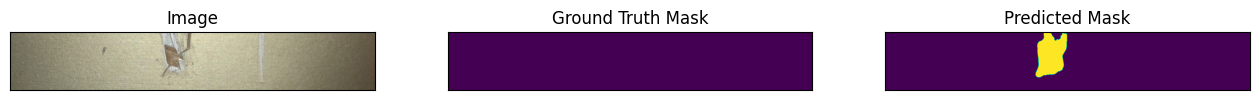

(3, 256, 1600)
torch.Size([1, 3, 256, 1600])


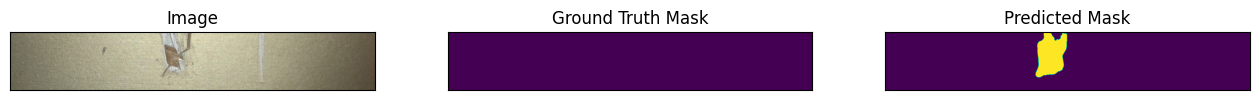

(3, 512, 1024)
torch.Size([1, 3, 512, 1024])


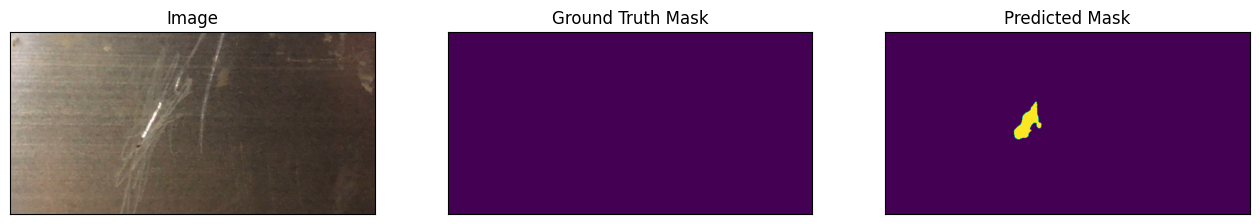

(3, 256, 1600)
torch.Size([1, 3, 256, 1600])


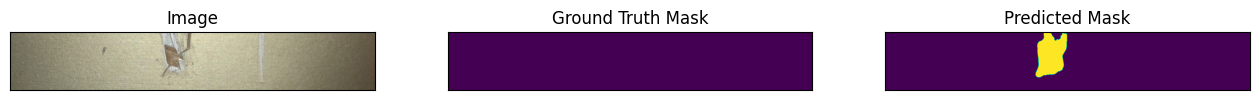

(3, 512, 1024)
torch.Size([1, 3, 512, 1024])


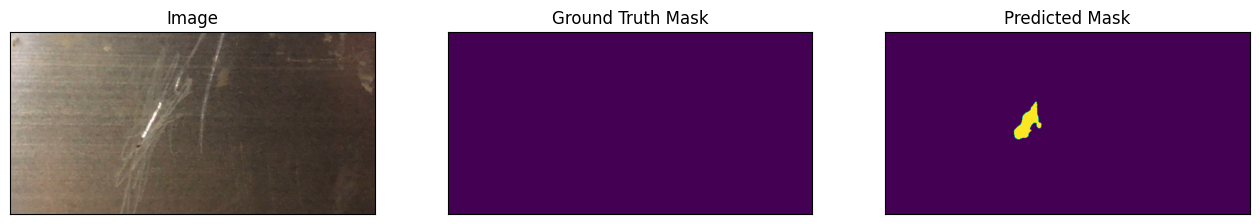

(3, 512, 1600)
torch.Size([1, 3, 512, 1600])


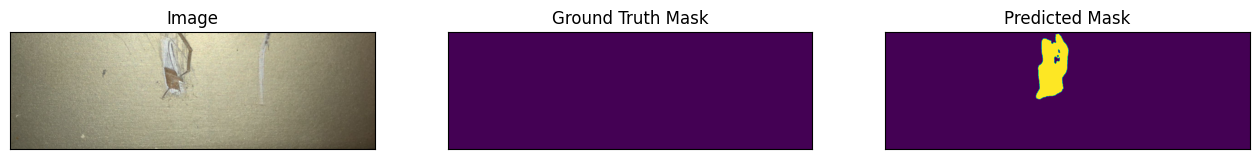

(3, 512, 1024)
torch.Size([1, 3, 512, 1024])


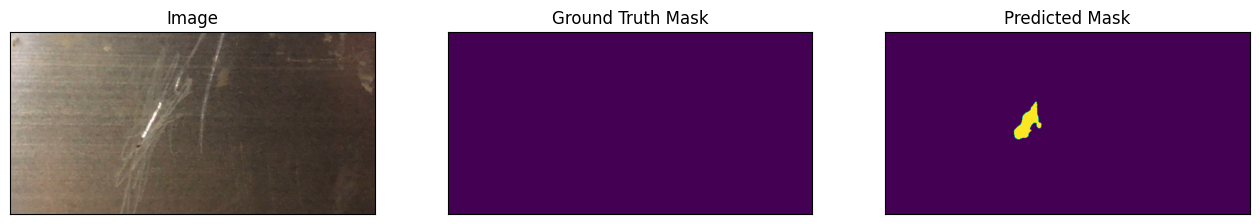

(3, 256, 1600)
torch.Size([1, 3, 256, 1600])


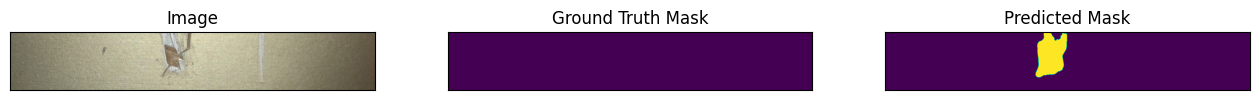

(3, 512, 1600)
torch.Size([1, 3, 512, 1600])


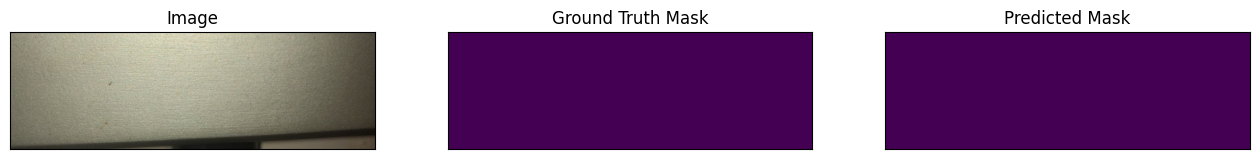

(3, 512, 1600)
torch.Size([1, 3, 512, 1600])


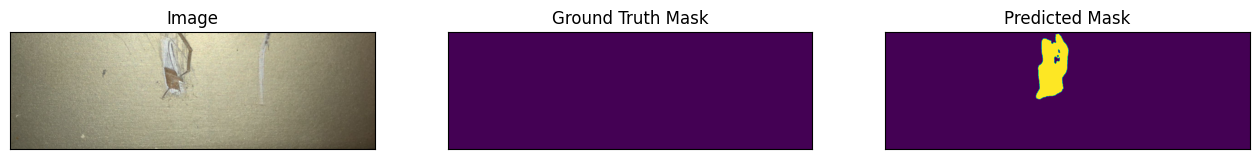

(3, 512, 1600)
torch.Size([1, 3, 512, 1600])


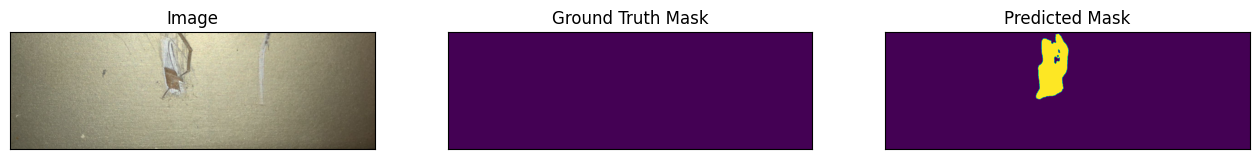

(3, 512, 1600)
torch.Size([1, 3, 512, 1600])


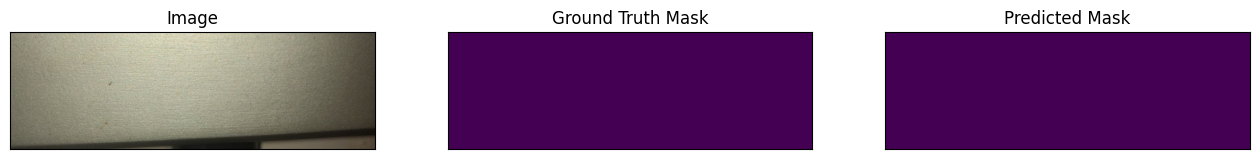

(3, 512, 1600)
torch.Size([1, 3, 512, 1600])


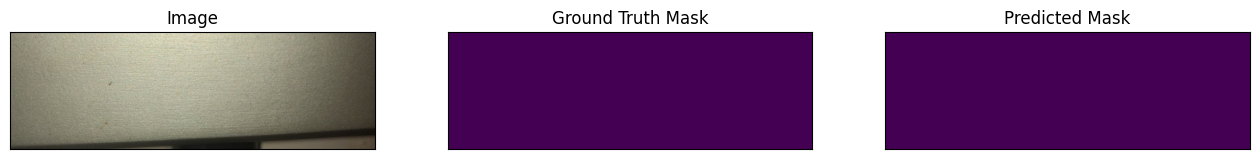

(3, 512, 1600)
torch.Size([1, 3, 512, 1600])


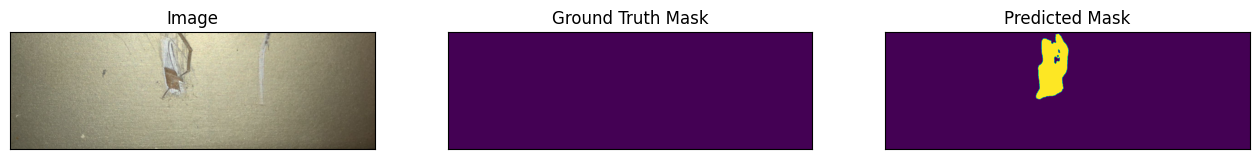

(3, 256, 1600)
torch.Size([1, 3, 256, 1600])


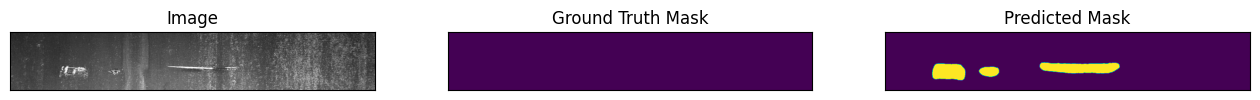

(3, 256, 1600)
torch.Size([1, 3, 256, 1600])


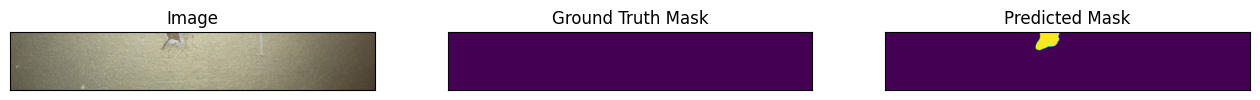

(3, 256, 1600)
torch.Size([1, 3, 256, 1600])


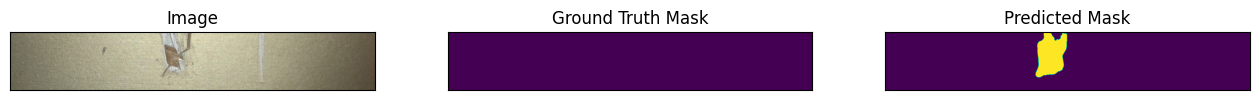

(3, 256, 1600)
torch.Size([1, 3, 256, 1600])


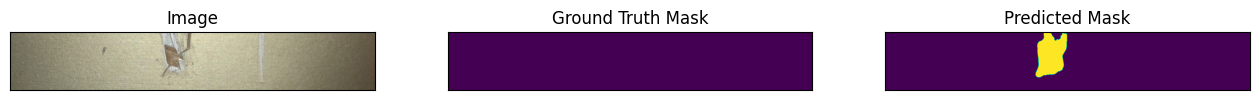

(3, 512, 1600)
torch.Size([1, 3, 512, 1600])


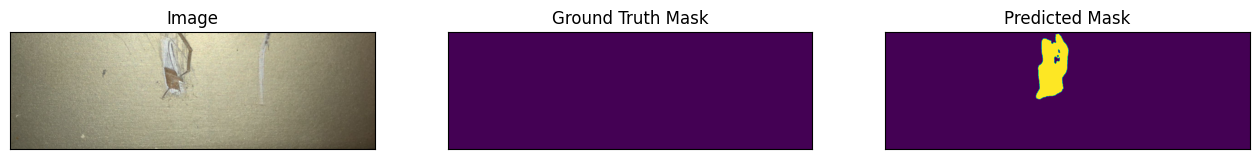

(3, 512, 1024)
torch.Size([1, 3, 512, 1024])


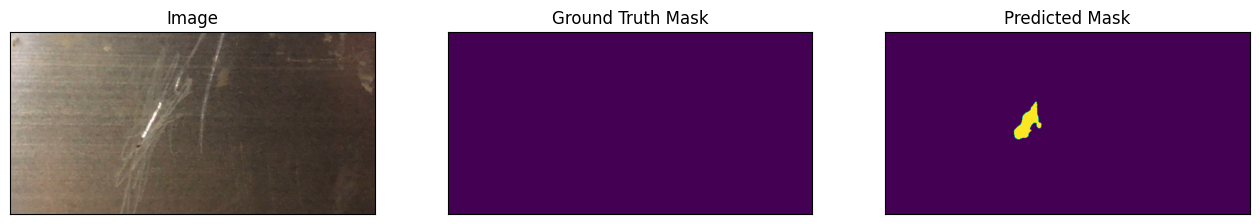

In [ ]:
for i in range(20):
    n = np.random.choice(len(test_dataset))

    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]

    gt_mask = gt_mask.squeeze()

    print(image.shape)

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    print(x_tensor.shape)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())

    visualize(
        image=image_vis,
        ground_truth_mask=gt_mask,
        predicted_mask=pr_mask
    )

In [ ]:
# from PIL import Image

# # Load the image
# image_path = '/content/test/e.jpg'
# image = Image.open(image_path)
# # Convert the image to a NumPy array
# image_array = np.array(image)
# image_array_transposed = np.transpose(image_array, (2, 0, 1))
# image_array_unsqueezed = np.expand_dims(image_array_transposed, axis=0)
# image_array_unsqueezed = image_array_unsqueezed[:,:,0:256,0:1024]
# x_tensor = torch.from_numpy(image_array_unsqueezed).to(DEVICE)
# x_tensor = x_tensor.to(torch.float)

# pr_mask = best_model.predict(x_tensor)
# pr_mask = (pr_mask.squeeze().cpu().numpy().round())

# plt.imshow(pr_mask)
# plt.title('Modified Image')
# plt.axis('off')

# plt.show()

